# Testing for Task 3

In [ ]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

### Q-Learning Implementation (without VFA)

##### MDP Parameters

In [ ]:
# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

##### Utility

In [ ]:
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_q_values(Q, label=None):
    """
    Utility function to print policies and corresponding Q values (can be multiple)
    """
    if label:
        print(f"===== Optimal Policy for {label} =====")
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = np.argmax(Q[comp_type], axis=0)
        policy[xi[comp_type]] = 1  # Force maintenance at threshold
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)

    print("\nQ-values for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(Q[comp_type])

##### Transition probabilities

In [ ]:
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

##### $\epsilon$-greedy action determination

In [ ]:
def choose_action(Q, comp_type, s, xi, epsilon):
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - Q         : Tuple of numpy arrays representing the Q-table for each component type.
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - xi        : Tuple containing the failure threshold for each component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1

    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        return np.argmax(Q[comp_type][:, s])

##### Q-Learning

In [ ]:
def run_QLearning(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    #* Initialize Q(s, a), ∀ s ∈ S, a ∈ A(s), arbitrarily
    Q = tuple(np.zeros((2, x + 1)) for x in xi)
    

    # Initialize other things    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    #* Repeat (for each episode):
    for i in tqdm(range(nEpisodes), desc="Episodes"):

        # Decaying learning rate
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))

        #* Initialize S
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
                
        # init max TD error
        max_TD_error = 0
        
        #* For Repeat (for each step of episode):
        for _ in range(0, lengthEpisode):

            #* Choose A from S using policy derived from Q using e-greedy
            a = choose_action(Q, comp_type, s, xi, epsilon)

            #* Take action A, observe S', comp_type'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                if s_prime > xi[comp_type]:
                    s_prime = xi[comp_type]
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            #* Take action A, observe R
            r = -C[comp_type][s][a]
            
            #* Q-Learning Update:
            #* Q(S, A) <- Q(S, A) + α[R + γ*max_a{Q(S', a)} – Q(S, A)]
            if s_prime == xi[comp_type_prime]:
                maxNextQ = Q[comp_type_prime][1,s_prime]
            else:
                maxNextQ = np.max(Q[comp_type_prime][:,s_prime])
            TD_error = r + gamma* maxNextQ - Q[comp_type][a][s]
            # update Q-value
            Q[comp_type][a][s] += alpha * TD_error

            # update max TD error
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)
            
            #* S <- S'
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # Early stopping based on stable policy
        if patience is not None:
            current_policy = tuple(np.argmax(Q[comp], axis=0) for comp in range(len(Q)))
            # Force maintenance at the threshold, bc forcing action 1 at th in choose_action(.)
            for k, policy in enumerate(current_policy):
                policy[xi[k]] = 1
            
            #
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD convergence
        if(max_TD_error) < delta:
            return TD_errors, Q
    
    return TD_errors, Q

Best Trial

In [ ]:
nEpisodes = pow(10, 5)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.2
initial_alpha = 0.05
decay_rate=10_000

td_errors, Q = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(Q)

Another trial

In [ ]:
nEpisodes = pow(10, 5)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.3
initial_alpha = 0.1
decay_rate=20_000

td_errors, Q = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_q_values(Q)

  0%|          | 200/100000 [00:09<1:20:52, 20.57it/s]

Stopped early at episode 201 — policy stable for 200 episodes.


### Trials Q-learning with VFA 

#### Trial 1 (BAD)

Episodes: 100%|██████████| 10000/10000 [06:37<00:00, 25.18it/s]


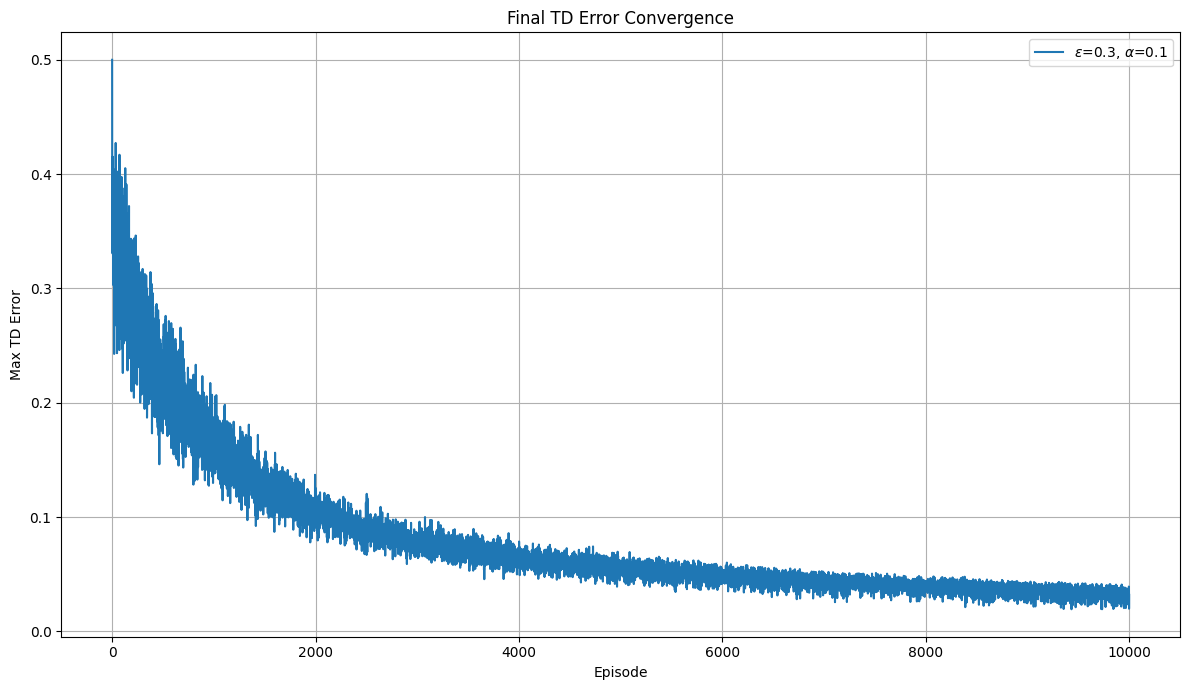

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Component Type 2 (Failure Threshold = 30):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Component Type 3 (Failure Threshold = 50):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Weights for each Component Type:
Component Type 1 (Failure Threshold = 15):
[[-2.21324056 -2.71215908]
 [-2.14011602 -3.65750474]]
Component Type 2 (Failure Threshold = 30):
[[-1.06949432 -3.06173223]
 [-1.21661859 -4.49067154]]
Component Type 3 (Failure Threshold = 50):
[[-0.35790398 -3.07790091]
 [-0.77287823 -4.63544528]]


In [7]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

###########################
##  Task 3 - Q-Learning with Linear Function Approximation  ##
###########################

# Define MDP parameters
actions = (0, 1)  # (0 = do nothing, 1 = maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Utility: fix the random seed
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)
    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_policies_and_weights(weights):
    """
    Utility function to print the derived policies and corresponding weights.
    """
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = []
        for s in range(xi[comp_type] + 1):
            if s == xi[comp_type]:
                policy.append(1)
            else:
                Q0 = get_Q_value(weights, comp_type, s, 0)
                Q1 = get_Q_value(weights, comp_type, s, 1)
                policy.append(0 if Q0 >= Q1 else 1)
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)
    
    print("\nWeights for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(weights[comp_type])

# Transition Probabilities setup (same as before)
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.
    """
    base_dist = getattr(stats, dist_name)
    if s == 0:
        prob_vector = [p_zero]
    else:
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        pmf_values[0] += p_zero
        p_s_or_more = 1 - np.sum(pmf_values)
        prob_vector = np.append(pmf_values, p_s_or_more)
    return prob_vector

# Helper: compute Q-value using linear function approximation
def get_Q_value(weights, comp_type, s, a):
    # Feature vector: [1, s/xi] where xi is the threshold for the component type.
    phi = np.array([1, s / xi[comp_type]])
    return np.dot(weights[comp_type][a], phi)

# Epsilon-greedy action selection using the approximated Q-values
def choose_action(weights, comp_type, s, epsilon):
    # Force maintenance if state reaches failure threshold.
    if s == xi[comp_type]:
        return 1
    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        Q0 = get_Q_value(weights, comp_type, s, 0)
        Q1 = get_Q_value(weights, comp_type, s, 1)
        return 0 if Q0 >= Q1 else 1

# Q-learning with linear function approximation
def run_QLearning(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta=1e-5, patience=None):
    # Initialize weights: one weight vector per component type and action.
    # Each weight vector is of dimension 2 corresponding to [bias, slope].
    weights = tuple(np.zeros((2, 2)) for _ in range(len(xi)))
    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    for i in tqdm(range(nEpisodes), desc="Episodes"):

        # Decay learning rate and epsilon over episodes
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))
        
        # Initialize state: choose a random component type and set degradation to 0.
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
        
        max_TD_error = 0

        for _ in range(lengthEpisode):

            # Choose action based on epsilon-greedy policy derived from approximated Q-values.
            a = choose_action(weights, comp_type, s, epsilon)

            # Take action, observe next state and next component type.
            if a == 0:
                # If not performing maintenance, degradation increases.
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type] - s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                s_prime = min(s_prime, xi[comp_type])  # Cap at failure threshold.
                comp_type_prime = comp_type
            else:
                # If performing maintenance, degradation resets and component type changes randomly.
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            # Reward is negative cost.
            r = -C[comp_type][s][a]
            
            # Compute Q(s,a) from the weights.
            Q_sa = get_Q_value(weights, comp_type, s, a)
            
            # Compute the target: if next state is terminal (at threshold) force maintenance value.
            if s_prime == xi[comp_type_prime]:
                maxNextQ = get_Q_value(weights, comp_type_prime, s_prime, 1)
            else:
                maxNextQ = max(get_Q_value(weights, comp_type_prime, s_prime, 0),
                               get_Q_value(weights, comp_type_prime, s_prime, 1))
            
            # TD error calculation
            TD_error = r + gamma * maxNextQ - Q_sa

            # Feature vector for current state-action pair
            phi = np.array([1, s / xi[comp_type]])
            
            # Update the weights: gradient descent step on the squared error.
            weights[comp_type][a] += alpha * TD_error * phi

            # Track maximum TD error for convergence
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)
            
            # Transition to next state and component type.
            s = s_prime
            comp_type = comp_type_prime

        TD_errors.append(max_TD_error)
        
        # Early stopping based on policy stability.
        if patience is not None:
            current_policy = []
            for comp in range(len(weights)):
                # Derive policy for each state of component type 'comp'
                policy = []
                for s_val in range(xi[comp] + 1):
                    if s_val == xi[comp]:
                        policy.append(1)
                    else:
                        Q0 = get_Q_value(weights, comp, s_val, 0)
                        Q1 = get_Q_value(weights, comp, s_val, 1)
                        policy.append(0 if Q0 >= Q1 else 1)
                current_policy.append(np.array(policy))
            
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD error convergence.
        if max_TD_error < delta:
            return TD_errors, weights

    return TD_errors, weights

# Parameters for learning.
nEpisodes = int(1e4)
lengthEpisode = int(1e3)
initial_epsilon = 0.3
initial_alpha = 0.1
decay_rate = 5_000

td_errors, weights = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, 
                                   initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)

final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_weights(weights)

In [ ]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

###########################
##  Task 3 - Q-Learning  ##
###########################

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Utility
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_weights(weights):
    """
    Utility function to print the derived policies and corresponding weights.
    """
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = []
        for s in range(xi[comp_type] + 1):
            if s == xi[comp_type]:
                policy.append(1)
            else:
                Q0 = get_Q_value(weights, comp_type, s, 0)
                Q1 = get_Q_value(weights, comp_type, s, 1)
                policy.append(0 if Q0 >= Q1 else 1)
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)
    
    print("\nWeights for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(weights[comp_type])

# Transition Probabilities
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector


# Helper: compute Q-value using linear function approximation
def get_Q_value(weights, comp_type, s, a):
    # Feature vector: [1, s/xi] where xi is the threshold for the component type.
    phi = np.array([1, s / xi[comp_type]])
    return np.dot(weights[comp_type][a], phi)

# e-greedy action determination for VFA
def choose_action_VFA(weights, comp_type, s, epsilon):
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - weights   : ...
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1
    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        Q0 = get_Q_value(weights,comp_type,s,0)
        Q1 = get_Q_value(weights,comp_type,s,1)
        return 0 if Q0 >= Q1 else 1
    

# Q-learning algo
def run_QLearning_VFA(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    
    #? initialize weight vector w = 0: one weight vector per component type and action.
    #? Each weight vector is of dimension 2 corresponding to [bias, slope (s/xi[comp_type])].
    w = tuple(np.zeros((2,2)) for _ in range(len(xi)))

    #? define feature function phi(s,a)
    ...

    # Initialize other things    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    #? Repeat (for each episode):
    for i in tqdm(range(nEpisodes), desc="Episodes"):

        # Decaying learning rate
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))

        #? Initialize S
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
                
        # init max TD error
        max_TD_error = 0
        
        #? Repeat (for each step of episode):
        for _ in range(0, lengthEpisode):

            #? Choose A from S using policy derived from Q using e-greedy
            a = choose_action_VFA(w, comp_type, s, epsilon)

            #? Take action A, observe S', comp_type'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                s_prime = min(s_prime,xi[comp_type])
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            #? Take action A, observe R
            r = -C[comp_type][s][a]
            
            #? Compute TD Error with VFA
            # compute max_a{W^T phi(S',a')}
            if s_prime == xi[comp_type_prime]:
                maxNextQ = get_Q_value(weights, comp_type_prime, s_prime, 1)
            else:
                maxNextQ = max(get_Q_value(weights, comp_type_prime, s_prime, 0),
                               get_Q_value(weights, comp_type_prime, s_prime, 1))
            # compute Q(s,a)
            Q_sa = get_Q_value(w,comp_type,s,a)

            # compute TD error
            TD_error = r + gamma * maxNextQ - Q_sa

            # update max TD error
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)

            #? Update weights
            # compute feature vector for current state-action pair
            phi_sa = np.array([1,s/xi[comp_type]])
            # update the weights w ← w + α × δ × φ(S, A)
            weights[comp_type][a] += alpha * TD_error * phi_sa

            #? S <- S' (and component type)
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # Early stopping based on policy stability.
        if patience is not None:
            current_policy = []
            for comp in range(len(weights)):
                # Derive policy for each state of component type 'comp'
                policy = []
                for s_val in range(xi[comp] + 1):
                    if s_val == xi[comp]:
                        policy.append(1)
                    else:
                        Q0 = get_Q_value(weights, comp, s_val, 0)
                        Q1 = get_Q_value(weights, comp, s_val, 1)
                        policy.append(0 if Q0 >= Q1 else 1)
                current_policy.append(np.array(policy))
            
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD error convergence.
        if max_TD_error < delta:
            return TD_errors, weights
    
    return TD_errors, Q

# Parameters for learning.
nEpisodes = pow(10, 4)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.3
initial_alpha = 0.1
decay_rate = 5_000

td_errors, weights = run_QLearning_VFA(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, 
                                   initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)

final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_weights(weights)

In [11]:
print_policies_and_weights(weights)

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Component Type 2 (Failure Threshold = 30):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Component Type 3 (Failure Threshold = 50):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Weights for each Component Type:
Component Type 1 (Failure Threshold = 15):
[[-2.21324056 -2.71215908]
 [-2.14011602 -3.65750474]]
Component Type 2 (Failure Threshold = 30):
[[-1.06949432 -3.06173223]
 [-1.21661859 -4.49067154]]
Component Type 3 (Failure Threshold = 50):
[[-0.35790398 -3.07790091]
 [-0.77287823 -4.63544528]]


#### Trial 2; feature vector 2

Episodes: 100%|██████████| 10000/10000 [06:49<00:00, 24.42it/s]


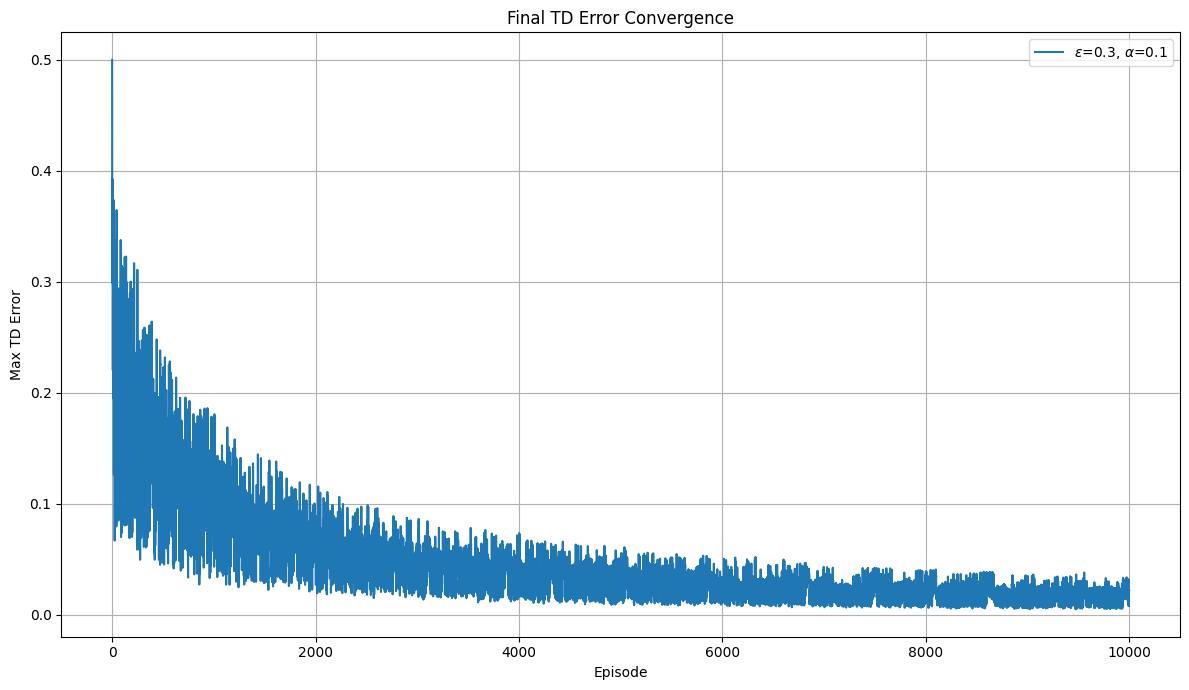

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1]
Component Type 2 (Failure Threshold = 30):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Component Type 3 (Failure Threshold = 50):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Weights for each Component Type:
Component Type 1 (Failure Threshold = 15):
[[ -0.99837649  -0.59168787  -0.50911315  -1.05716155]
 [ -1.65310195  -3.25478573  12.32570155 -10.97075189]]
Component Type 2 (Failure Threshold = 30):
[[-0.51344207 -0.90211504  0.73908103 -2.10526649]
 [-1.60069492 -1.43720685  6.28781216 -5.64519922]]
Component Type 3 (Failure Threshold = 50):
[[-0.35177178 -1.24921861 -0.01757788 -2.93027171]
 [-1.0352772  -2.17610181  6.68996222 -7.92622437]]


In [2]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

###########################
##  Task 3 - Q-Learning  ##
###########################

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Utility
np.random.seed(0)

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot results (can be multiple)
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)

    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def print_policies_and_weights(weights):
    """
    Utility function to print the derived policies and corresponding weights.
    """
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = []
        for s in range(xi[comp_type] + 1):
            if s == xi[comp_type]:
                policy.append(1)
            else:
                Q0 = get_Q_value(weights, comp_type, s, 0)
                Q1 = get_Q_value(weights, comp_type, s, 1)
                policy.append(0 if Q0 >= Q1 else 1)
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)
    
    print("\nWeights for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(weights[comp_type])

# Transition Probabilities
p_zero = 0.5  # 50% probability of zero inflation
dist_name = 'poisson'  # Base distribution
lambda_poisson = 4  # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.

    Parameters:
    - p_zero (float): Probability of zero inflation.
    - dist_name (str): Name of the base distribution ('poisson', 'nbinom', 'binom').
    - dist_params (tuple): Parameters of the base distribution.
    - s (int): Threshold for "s or greater" category.

    Returns:
    - np.array: Probability vector of length (s+1) where:
        - First element: P(X=0)
        - Second element: P(X=1)
        - ...
        - Second-to-last element: P(X=s-1)
        - Last element: P(X >= s)=1-(P(X=0)+...+P(X=s-1))
    """
    # Get the chosen probability mass function (PMF)
    base_dist = getattr(stats, dist_name)

    if s==0:
        prob_vector = [p_zero]
    else:
        # Compute probabilities for values 0 to (s-1)
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        
        # Adjust probability of zero (includes zero-inflation)
        pmf_values[0] += p_zero
        
        # Compute probability for X ≥ s
        p_s_or_more = 1 - np.sum(pmf_values)
        
        # Append P(X >= s) as the last element
        prob_vector = np.append(pmf_values, p_s_or_more)
    
    return prob_vector

# Improved feature vector: using polynomial features degree 3
def feature_vector(comp_type, s):
    norm_s = s / xi[comp_type]  # Normalize s to [0, 1]
    return np.array([1, norm_s, norm_s**2, norm_s**3])

# Helper: compute Q-value using linear function approximation
def get_Q_value(weights, comp_type, s, a):
    # Feature vector: [1, s/xi] where xi is the threshold for the component type.
    phi = feature_vector(comp_type,s)
    return np.dot(weights[comp_type][a], phi)

# e-greedy action determination for VFA
def choose_action_VFA(weights, comp_type, s, epsilon):
    """
    Choose an action using an epsilon-greedy policy with a forced action at the threshold.

    Parameters:
     - weights   : ...
     - comp_type : Integer index indicating the component type.
     - s         : Current state (an integer) for the selected component type.
     - epsilon   : Exploration probability.

    Returns:
     - a         : The chosen action (0 or 1). If s equals the threshold (xi[comp_type]), then returns 1.
    """
    # If state equals the failure threshold, force the maintenance action.
    if s == xi[comp_type]:
        return 1
    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        Q0 = get_Q_value(weights,comp_type,s,0)
        Q1 = get_Q_value(weights,comp_type,s,1)
        return 0 if Q0 >= Q1 else 1
    
# Q-learning with VFA algo
def run_QLearning_VFA(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta = 1e-5, patience=None):
    
    #? initialize weight vector w = 0: one weight vector per component type and action.
    #? Each weight vector is of dimension 2 corresponding to [bias, slope (s/xi[comp_type])].
    weights = tuple(np.zeros((2,4)) for _ in range(len(xi)))

    #? define feature function phi(s,a)
    ...

    # Initialize other things    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    #? Repeat (for each episode):
    for i in tqdm(range(nEpisodes), desc="Episodes"):

        # Decaying learning rate
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))

        #? Initialize S
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
                
        # init max TD error
        max_TD_error = 0
        
        #? Repeat (for each step of episode):
        for _ in range(0, lengthEpisode):

            #? Choose A from S using policy derived from Q using e-greedy
            a = choose_action_VFA(weights, comp_type, s, epsilon)

            #? Take action A, observe S', comp_type'
            if a == 0:
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type]-s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                s_prime = min(s_prime,xi[comp_type])
                comp_type_prime = comp_type
            else:
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            #? Take action A, observe R
            r = -C[comp_type][s][a]
            
            #? Compute TD Error with VFA
            # compute max_a{W^T phi(S',a')}
            if s_prime == xi[comp_type_prime]:
                maxNextQ = get_Q_value(weights, comp_type_prime, s_prime, 1)
            else:
                maxNextQ = max(get_Q_value(weights, comp_type_prime, s_prime, 0),
                               get_Q_value(weights, comp_type_prime, s_prime, 1))
            # compute Q(s,a)
            Q_sa = get_Q_value(weights,comp_type,s,a)

            # compute TD error
            TD_error = r + gamma * maxNextQ - Q_sa

            # update max TD error
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)

            #? Update weights
            # compute feature vector for current state-action pair
            phi_sa = feature_vector(comp_type,s)
            # update the weights w ← w + α × δ × φ(S, A)
            weights[comp_type][a] += alpha * TD_error * phi_sa

            #? S <- S' (and component type)
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # Early stopping based on policy stability.
        if patience is not None:
            current_policy = []
            for comp in range(len(weights)):
                # Derive policy for each state of component type 'comp'
                policy = []
                for s_val in range(xi[comp] + 1):
                    if s_val == xi[comp]:
                        policy.append(1)
                    else:
                        Q0 = get_Q_value(weights, comp, s_val, 0)
                        Q1 = get_Q_value(weights, comp, s_val, 1)
                        policy.append(0 if Q0 >= Q1 else 1)
                current_policy.append(np.array(policy))
            
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD error convergence.
        if max_TD_error < delta:
            return TD_errors, weights
    
    return TD_errors, weights

# Parameters for learning.
nEpisodes = pow(10, 4)
lengthEpisode = pow(10, 3)
initial_epsilon = 0.3
initial_alpha = 0.1
decay_rate = 5_000

td_errors, weights = run_QLearning_VFA(nEpisodes, lengthEpisode, initial_epsilon=initial_epsilon, 
                                   initial_alpha=initial_alpha, decay_rate=decay_rate, patience=200)

final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_weights(weights)

#### Trial 4: One-hot encoding for the (s,a) pair defined per component type

In [3]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

###########################
##  Q-Learning with Linear Function Approximation using One-Hot Encoding (Version 1)  ##
###########################

# MDP parameters:
actions = (0, 1)  # 0 = do nothing, 1 = maintenance
xi = (15, 30, 50) # failure thresholds for each component type
S = [list(range(x + 1)) for x in xi]
# Cost structure: for each component type, the cost array is defined for each state and action.
# (Here we assume that for states less than the threshold, costs are defined by [0, 1] and at the threshold,
# maintenance is forced with cost 5, and doing nothing is infeasible (set to infinity).)
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Fix the random seed for reproducibility
np.random.seed(0)

# -----------------------
# Version 1 Feature Functions
# -----------------------

def feature_vector(comp_type, s, a):
    """
    One-hot encoding for (s, a) given the component type.
    The feature vector length is: (xi[comp_type] + 1) * 2.
    Each state–action pair is mapped as:
         index = s * 2 + a.
    """
    length = (xi[comp_type] + 1) * 2
    phi = np.zeros(length)
    idx = s * 2 + a
    phi[idx] = 1.0
    return phi

def get_Q_value(weights, comp_type, s, a):
    """
    Returns the approximated Q-value as the dot product between the weight vector
    (for the given component type) and the one-hot feature vector for (s, a).
    """
    phi = feature_vector(comp_type, s, a)
    return np.dot(weights[comp_type], phi)

def choose_action(weights, comp_type, s, epsilon):
    """
    Epsilon-greedy action selection.
    Force maintenance (action 1) when s reaches the threshold.
    """
    if s == xi[comp_type]:
        return 1  # Force maintenance at the threshold.
    if np.random.random() < epsilon:
        return np.random.randint(2)
    else:
        Q0 = get_Q_value(weights, comp_type, s, 0)
        Q1 = get_Q_value(weights, comp_type, s, 1)
        return 0 if Q0 >= Q1 else 1

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.
    """
    base_dist = getattr(stats, dist_name)
    if s == 0:
        prob_vector = [p_zero]
    else:
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        pmf_values[0] += p_zero
        p_s_or_more = 1 - np.sum(pmf_values)
        prob_vector = np.append(pmf_values, p_s_or_more)
    return prob_vector

def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot the maximum TD error per episode.
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)
    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_policies_and_weights(weights):
    """
    Print the derived policy (action chosen for each state) and the learned weight vectors.
    """
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = []
        for s in range(xi[comp_type] + 1):
            if s == xi[comp_type]:
                policy.append(1)
            else:
                Q0 = get_Q_value(weights, comp_type, s, 0)
                Q1 = get_Q_value(weights, comp_type, s, 1)
                policy.append(0 if Q0 >= Q1 else 1)
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)
    
    print("\nWeights for each Component Type:")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(weights[comp_type])

def run_QLearning(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                   delta=1e-5, patience=None):
    # Initialize a weight vector per component type.
    # Each weight vector has dimension = (xi[comp_type] + 1) * 2.
    weights = []
    for comp_type in range(len(xi)):
        feature_dim = (xi[comp_type] + 1) * 2
        weights.append(np.zeros(feature_dim))
    weights = tuple(weights)
    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    # Parameters for the zero-inflated process
    p_zero = 0.5      # 50% probability of zero inflation
    dist_name = 'poisson'
    lambda_poisson = 4

    for i in tqdm(range(nEpisodes), desc="Episodes"):
        # Decay learning rate and epsilon over episodes.
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))
        
        # Initialize state: select a random component type, starting at s = 0.
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]
        max_TD_error = 0

        for _ in range(lengthEpisode):
            # Select an action using the epsilon-greedy policy.
            a = choose_action(weights, comp_type, s, epsilon)
            
            # Execute action a:
            if a == 0:
                # If doing nothing, the degradation increases.
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type] - s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                s_prime = min(s_prime, xi[comp_type])  # Ensure s' does not exceed the threshold.
                comp_type_prime = comp_type
            else:
                # If maintenance is performed, degradation resets and a new component type is chosen.
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            # Observe the reward.
            r = -C[comp_type][s][a]
            
            # Compute current Q-value and target value.
            Q_sa = get_Q_value(weights, comp_type, s, a)
            if s_prime == xi[comp_type_prime]:
                maxNextQ = get_Q_value(weights, comp_type_prime, s_prime, 1)
            else:
                Q0 = get_Q_value(weights, comp_type_prime, s_prime, 0)
                Q1 = get_Q_value(weights, comp_type_prime, s_prime, 1)
                maxNextQ = max(Q0, Q1)
            
            TD_error = r + gamma * maxNextQ - Q_sa
            phi = feature_vector(comp_type, s, a)
            # Update the weight vector for the current component type.
            weights[comp_type] += alpha * TD_error * phi
            
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)
            
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # Early stopping based on policy stability.
        if patience is not None:
            current_policy = []
            for comp in range(len(weights)):
                policy = []
                for s_val in range(xi[comp] + 1):
                    if s_val == xi[comp]:
                        policy.append(1)
                    else:
                        Q0 = get_Q_value(weights, comp, s_val, 0)
                        Q1 = get_Q_value(weights, comp, s_val, 1)
                        policy.append(0 if Q0 >= Q1 else 1)
                current_policy.append(np.array(policy))
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        if max_TD_error < delta:
            return TD_errors, weights
    
    return TD_errors, weights

# Learning parameters.
nEpisodes = int(1e5)
lengthEpisode = int(1e3)
initial_epsilon = 0.2
initial_alpha = 0.05
decay_rate = 10_000

td_errors, weights = run_QLearning(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, decay_rate=decay_rate, patience=200)
final_results = {f"$\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors}}
plot_td_errors(final_results, title="Final TD Error Convergence")
print_policies_and_weights(weights)

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]


TypeError: 'tuple' object does not support item assignment

### Double Q-Learning with VFA

Episodes (Double Q-Learning):  33%|███▎      | 3307/10000 [02:14<04:32, 24.57it/s]

Stopped early at episode 3308 — policy stable for 200 episodes.


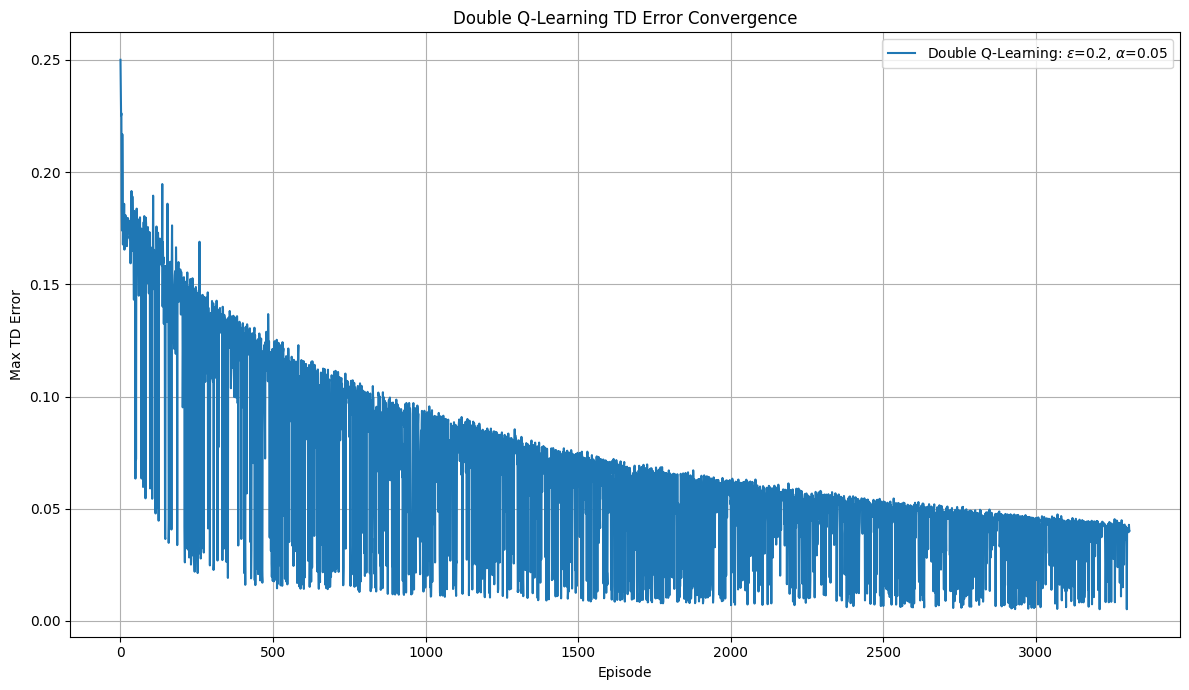

Optimal Policy (0 = Do nothing, 1 = Maintenance):
Component Type 1 (Failure Threshold = 15):
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Component Type 2 (Failure Threshold = 30):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
Component Type 3 (Failure Threshold = 50):
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

Weights for each Component Type (Double Q-Learning):
Component Type 1 (Failure Threshold = 15):
Weights1: [-0.94034063 -1.47683898 -1.00720287 -1.43441355 -1.06941164 -1.44306253
 -1.12737519 -1.48926979 -1.15723862 -1.50699771 -1.20944115 -1.50123219
 -1.24493617 -1.45795186 -1.38448172 -1.48434415 -1.55718409 -1.50890829
 -1.71633674 -1.43775373 -2.12957473 -1.46871537 -2.51649713 -1.46911501
 -2.5510593  -1.46662324 -3.33355235 -1.45561634 -2.92525324 -1.47593191
  0.         -5.47824746]
Weights2: [-0.95358408 -1.

In [4]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

########################################################################################
##  Double Q-Learning with Linear Function Approximation using One-Hot Encoding (VFA)  ##
########################################################################################

# Define MDP parameters
actions = (0, 1)  # (0=do nothing, 1=maintenance)
xi = (15, 30, 50) # break threshold per type of component
S = [list(range(x + 1)) for x in xi]
C = tuple([[0, 1]] * x + [[math.inf, 5]] for x in xi)
gamma = 0.9  # Discount factor

# Fix the random seed for reproducibility
np.random.seed(0)

# ---------------------
# Utility Functions
# ---------------------
def plot_td_errors(results, title="TD Error Convergence"):
    """
    Utility function to plot the maximum TD error per episode.
    """
    plt.figure(figsize=(12, 7))
    for label, data in results.items():
        plt.plot(data["td_errors"], label=label)
    plt.xlabel("Episode")
    plt.ylabel("Max TD Error")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def print_double_policies_and_weights(weights1, weights2):
    """
    Print the derived policy (using combined Q-values) and the learned weight vectors for each component type.
    """
    print("Optimal Policy (0 = Do nothing, 1 = Maintenance):")
    for comp_type in range(len(xi)):
        policy = []
        for s in range(xi[comp_type] + 1):
            if s == xi[comp_type]:
                policy.append(1)
            else:
                Q0 = get_Q_value(weights1, comp_type, s, 0) + get_Q_value(weights2, comp_type, s, 0)
                Q1 = get_Q_value(weights1, comp_type, s, 1) + get_Q_value(weights2, comp_type, s, 1)
                policy.append(0 if Q0 >= Q1 else 1)
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print(policy)
    
    print("\nWeights for each Component Type (Double Q-Learning):")
    for comp_type in range(len(xi)):
        print(f"Component Type {comp_type + 1} (Failure Threshold = {xi[comp_type]}):")
        print("Weights1:", weights1[comp_type])
        print("Weights2:", weights2[comp_type])

# ---------------------
# Transition Probabilities
# ---------------------
p_zero = 0.5            # 50% probability of zero inflation
dist_name = 'poisson'   # Base distribution
lambda_poisson = 4      # Poisson mean

def zero_inflated_prob_vector(p_zero, dist_name, dist_params, s):
    """
    Computes a probability vector for a zero-inflated random variable.
    """
    base_dist = getattr(stats, dist_name)
    if s == 0:
        prob_vector = [p_zero]
    else:
        pmf_values = (1 - p_zero) * base_dist.pmf(np.arange(s), *dist_params)
        pmf_values[0] += p_zero  # include zero-inflation
        p_s_or_more = 1 - np.sum(pmf_values)
        prob_vector = np.append(pmf_values, p_s_or_more)
    return prob_vector

# ---------------------
# Feature Extraction and Q-value Calculation
# ---------------------
def feature_vector(comp_type, s, a):
    """
    One-hot encoding for (s, a) given the component type.
    The feature vector length is: (xi[comp_type] + 1) * 2.
    Each state-action pair is mapped as: index = s * 2 + a.
    """
    length = (xi[comp_type] + 1) * 2
    phi = np.zeros(length)
    idx = s * 2 + a
    phi[idx] = 1.0
    return phi

def get_Q_value(weights, comp_type, s, a):
    """
    Returns the approximated Q-value as the dot product between the weight vector (for the given component type)
    and the one-hot feature vector for (s, a).
    """
    phi = feature_vector(comp_type, s, a)
    return np.dot(weights[comp_type], phi)

# ---------------------
# Double Q-Learning with VFA
# ---------------------
def run_Double_QLearning_VFA(nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, min_epsilon=0.01, decay_rate=5000, 
                             delta=1e-5, patience=None):
    """
    Runs Double Q-Learning with VFA.
    Initializes two sets of weight vectors (weights1 and weights2) and alternates updates between them.
    """
    # Initialize two sets of weights (one for each Q-estimator) for each component type.
    weights1 = []
    weights2 = []
    for comp_type in range(len(xi)):
        feature_dim = (xi[comp_type] + 1) * 2
        weights1.append(np.zeros(feature_dim))
        weights2.append(np.zeros(feature_dim))
    
    TD_errors = []
    prev_policy = None
    stable_count = 0

    for i in tqdm(range(nEpisodes), desc="Episodes (Double Q-Learning)"):
        # Decay learning rate and epsilon over episodes.
        alpha = initial_alpha / (1 + i / 1000)
        epsilon = max(min_epsilon, initial_epsilon * np.exp(-i / decay_rate))
        
        # Initialize starting state and component type.
        comp_type = np.random.randint(0, 3)
        s = S[comp_type][0]

        max_TD_error = 0

        for _ in range(lengthEpisode):
            # -------------------------
            # Action Selection (ε-greedy using combined Q-values)
            # -------------------------
            if s == xi[comp_type]:
                a = 1  # Force maintenance if at threshold.
            elif np.random.random() < epsilon:
                a = np.random.randint(2)
            else:
                Q0 = get_Q_value(weights1, comp_type, s, 0) + get_Q_value(weights2, comp_type, s, 0)
                Q1 = get_Q_value(weights1, comp_type, s, 1) + get_Q_value(weights2, comp_type, s, 1)
                a = 0 if Q0 >= Q1 else 1
            
            # -------------------------
            # Observe Next State and Reward
            # -------------------------
            if a == 0:
                # If doing nothing, degradation increases (or stays the same).
                prob_vector = zero_inflated_prob_vector(p_zero, dist_name, (lambda_poisson,), xi[comp_type] - s)
                increments = np.arange(len(prob_vector))
                increment = np.random.choice(increments, p=prob_vector)
                s_prime = s + increment
                s_prime = min(s_prime, xi[comp_type])
                comp_type_prime = comp_type
            else:
                # If maintenance, reset degradation and choose a new component type.
                s_prime = 0
                comp_type_prime = np.random.randint(0, 3)
            
            r = -C[comp_type][s][a]
            
            # -------------------------
            # Double Q-Learning Update
            # -------------------------
            # Randomly decide which estimator to update.
            if np.random.rand() < 0.5:
                # Update weights1:
                Q_sa = get_Q_value(weights1, comp_type, s, a)
                
                # Select next action using weights1.
                if s_prime == xi[comp_type_prime]:
                    a_star = 1  # Force maintenance.
                else:
                    Q1_0 = get_Q_value(weights1, comp_type_prime, s_prime, 0)
                    Q1_1 = get_Q_value(weights1, comp_type_prime, s_prime, 1)
                    a_star = 0 if Q1_0 >= Q1_1 else 1
                
                # Evaluate the next state using weights2.
                Q2_next = get_Q_value(weights2, comp_type_prime, s_prime, a_star)
                target = r + gamma * Q2_next
                TD_error = target - Q_sa
                
                # Update weights1 for the current component type.
                weights1[comp_type] += alpha * TD_error * feature_vector(comp_type, s, a)
            else:
                # Update weights2:
                Q_sa = get_Q_value(weights2, comp_type, s, a)
                
                # Select next action using weights2.
                if s_prime == xi[comp_type_prime]:
                    a_star = 1
                else:
                    Q2_0 = get_Q_value(weights2, comp_type_prime, s_prime, 0)
                    Q2_1 = get_Q_value(weights2, comp_type_prime, s_prime, 1)
                    a_star = 0 if Q2_0 >= Q2_1 else 1
                
                # Evaluate the next state using weights1.
                Q1_next = get_Q_value(weights1, comp_type_prime, s_prime, a_star)
                target = r + gamma * Q1_next
                TD_error = target - Q_sa
                
                # Update weights2 for the current component type.
                weights2[comp_type] += alpha * TD_error * feature_vector(comp_type, s, a)
            
            if abs(alpha * TD_error) > max_TD_error:
                max_TD_error = abs(alpha * TD_error)
            
            # Transition to next state.
            s = s_prime
            comp_type = comp_type_prime
        
        TD_errors.append(max_TD_error)
        
        # -------------------------
        # Policy Stability Check (using combined Q-values)
        # -------------------------
        if patience is not None:
            current_policy = []
            for comp in range(len(xi)):
                policy = []
                for s_val in range(xi[comp] + 1):
                    if s_val == xi[comp]:
                        policy.append(1)
                    else:
                        Q0 = get_Q_value(weights1, comp, s_val, 0) + get_Q_value(weights2, comp, s_val, 0)
                        Q1 = get_Q_value(weights1, comp, s_val, 1) + get_Q_value(weights2, comp, s_val, 1)
                        policy.append(0 if Q0 >= Q1 else 1)
                current_policy.append(np.array(policy))
            
            if prev_policy is not None and all(np.array_equal(cp, pp) for cp, pp in zip(current_policy, prev_policy)):
                stable_count += 1
                if stable_count >= patience:
                    print(f"Stopped early at episode {i+1} — policy stable for {patience} episodes.")
                    break
            else:
                stable_count = 0
                prev_policy = current_policy
        
        # Early stopping based on TD error convergence.
        if max_TD_error < delta:
            return TD_errors, (weights1, weights2)
    
    return TD_errors, (weights1, weights2)

# ---------------------
# Running the Double Q-Learning Algorithm
# ---------------------
nEpisodes = int(1e4)
lengthEpisode = int(1e3)
initial_epsilon = 0.2
initial_alpha = 0.05
decay_rate = 10_000

td_errors_double, (weights1, weights2) = run_Double_QLearning_VFA(
    nEpisodes, lengthEpisode, initial_epsilon, initial_alpha, decay_rate=decay_rate, patience=200
)

final_results_double = {f"Double Q-Learning: $\\epsilon$={initial_epsilon}, $\\alpha$={initial_alpha}": {"td_errors": td_errors_double}}
plot_td_errors(final_results_double, title="Double Q-Learning TD Error Convergence")
print_double_policies_and_weights(weights1, weights2)